In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sympy
from scipy.optimize import curve_fit
from copy import deepcopy
import matplotlib
%matplotlib inline

確率密度分布の推移を求める
状態名と遷移過程と半減期をインプット
分解しかしないパターンを実装した
数密度に左右されるような過渡状態を持つ場合、別のコードが必要

In [73]:
state_numbers = {
    "A": 0, #   状態名:通し番号
    "B": 1,
    "C": 2,
    "D": 3,
}

states_graph = [
    ("A", "B", float("inf"), 1, True),# 遷移前の状態, 遷移後の状態, 遷移前の状態の寿命, 数密度何倍になるか,　遷移先の状態は光励起直後か
    ("B", "C", 0.5, 1, False),
    ("C", "A", 2.5, 1, False),
]

bins = 10**4
before_lay_time_range = 1
after_lay_time_range = 9
lay_width_time_range = 0.25
time_range = before_lay_time_range + after_lay_time_range

In [74]:
lay_d = np.exp(-(np.arange(bins) - bins*0.1)**2/(bins*lay_width_time_range/time_range)**2)
lay_d /= np.sum(lay_d)

tl = [0.0]*len(state_numbers)
dp = [[0.0]*bins for _ in range(len(state_numbers))]

dp_index_graph = [[] for _ in range(len(state_numbers))]
lay_TFs = [False]*len(state_numbers)
for s1, s2, T, amp, lay_TF in states_graph:
    dp_index_graph[state_numbers[s1]].append((state_numbers[s2], T, amp))
    lay_TFs[state_numbers[s2]] = lay_TF
    if lay_TF:
        tl[state_numbers[s1]] = 1.0 # 初期密度が0ではない場合の値の代入。本当は、光への感度に比例した値を入れる必要がある


for t in range(bins):
    for i in range(len(dp_index_graph)):#   遷移元ループ
        for j, T, amp in dp_index_graph[i]:#    遷移先ループ
            if lay_TFs[j]:  #   指定された遷移先が光励起直後だった場合(指定された遷移元が入射前の定常状態だった場合)
                tl[i] -= lay_d[t]
                tl[j] += amp*lay_d[t]
            else:
                delta = tl[i] * (1.0 - np.exp(-(time_range/bins)/T))
                tl[i] -= delta
                tl[j] += amp*delta

            dp[i][t] = tl[i]
            dp[j][t] = tl[j]

0.0022567583513024977 0.9999999999999999


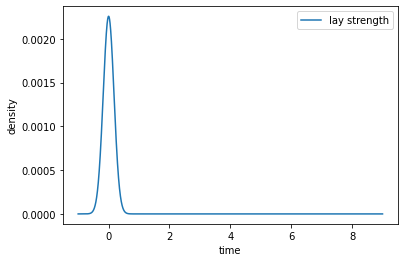

In [75]:
print(np.max(lay_d), np.sum(lay_d))
t = (np.arange(bins) - bins*before_lay_time_range/time_range)/bins*time_range
plt.plot(t, lay_d, label="lay strength")
plt.xlabel("time")
plt.ylabel("density")
plt.legend()
plt.savefig("result.png")

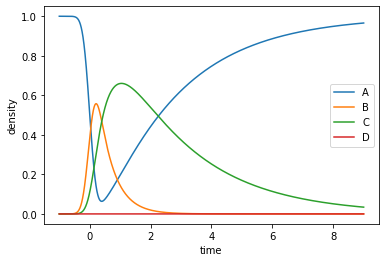

In [76]:
t = (np.arange(bins) - bins*before_lay_time_range/time_range)/bins*time_range
for state in state_numbers:
    plt.plot(t, dp[state_numbers[state]], label=state)
plt.xlabel("time")
plt.ylabel("density")
plt.legend()
plt.savefig("result.png")

In [77]:
#　各過渡状態が持つ吸光度を導入し、すべての状態のミックスの吸光度の時間変化を計算する
absorbance_dic = {
    "A":None,
    "B":None,
    "C":None,
    "D":None,
}
def gaussian_arr_creator(mean, std, max_density=1, ramda_lst=[i for i in range(200, 1000)]):
    ramda_arr = np.array(ramda_lst)
    return ramda_arr, max_density*np.exp(-(ramda_arr - mean)**2/std**2)

ramda_arr, A_arr = gaussian_arr_creator(mean=350, std=10, max_density=0.2)
ramda_arr, B_arr = gaussian_arr_creator(mean=700, std=10, max_density=1.0)
ramda_arr, C_arr = gaussian_arr_creator(mean=600, std=10, max_density=0.5)
ramda_arr, D_arr = gaussian_arr_creator(mean=400, std=10, max_density=0.2)
absorbance_dic["A"] = A_arr
absorbance_dic["B"] = B_arr
absorbance_dic["C"] = C_arr
absorbance_dic["D"] = D_arr

In [78]:
ramda_arr

array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
       278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
       291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303,
       304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
       317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
       330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 38

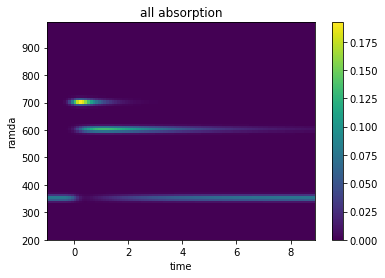

In [79]:
X, Y = 100, 100 #   X,Y軸のグリッド数
t = (np.arange(bins) - bins*before_lay_time_range/time_range)/bins*time_range
t_grid, ramda_grid = np.meshgrid(t[::max(1, len(t)//X)], ramda_arr[::max(1, len(ramda_arr)//Y)])

exist_colorbar = False
abs_sum_arr = None
for name in state_numbers:
    if name in absorbance_dic:
        abs_arr = np.outer(absorbance_dic[name][::max(1, len(ramda_arr)//X)], dp[state_numbers[name]][::max(1, len(t)//Y)])

        #plt.pcolor(abs_arr)
        plt.pcolor(t_grid, ramda_grid, abs_arr[:-1,:-1])
        plt.xlabel("time")
        plt.ylabel("ramda")
        plt.title(name)
        if not exist_colorbar:
            plt.colorbar()
            exist_colorbar = True
        plt.savefig("absorption"+name+".png")
        if abs_sum_arr is None:
            abs_sum_arr = abs_arr
        else:
            abs_sum_arr += abs_arr
        

plt.pcolor(t_grid, ramda_grid, abs_sum_arr[:-1,:-1])
plt.xlabel("time")
plt.ylabel("ramda")
plt.title("all absorption")
plt.savefig("all absorption.png")

フィッティングには　SciPyのcurve_fitを使う予定だが、MCMCでパラメータの確率分布を求めるのもオプションとしてあり

Abs{λ)=Σ_t=1^100 absorption(λ, t) でピークの波長と幅を決める
scipy でAbs{λ)をフィッティング、ピーク位置とピーク強度パラメータと幅パラメータを得る

各ピーク強度の時間変化を決める。
ピーク位置パラメータと幅パラメータを既知の値として使いつつ、フィッティングしてピーク強度パラメータを出力する

ピーク強度の時間変化(規格化済み)の内積を取り、
内積が大きい組み合わせから「指定された過渡状態の数」になるまで同期している組み合わせを統合する

各過渡状態の遷移グラフと時間数密度分布(正規化)を計算

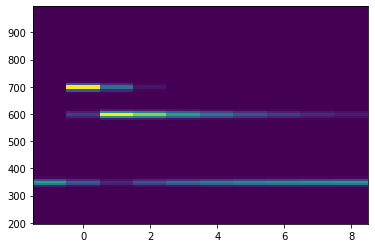

In [91]:
observed_t = t[::len(t)//10]
observed_ramda = ramda_arr[::len(ramda_arr)//100]
observed_t_grid, observed_ramda_grid = np.meshgrid(observed_t, observed_ramda)
observed_absorption = deepcopy(abs_sum_arr[::max(1, len(abs_sum_arr[0])//len(observed_ramda)), ::max(1, len(abs_sum_arr[0])//len(observed_t))])

plt.pcolor(observed_t_grid, observed_ramda_grid, observed_absorption)

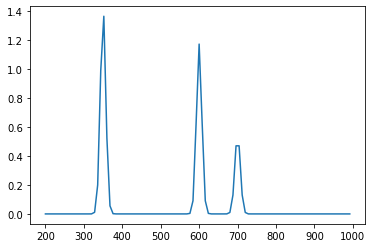

In [93]:
absorption_peaks_N = 3
absorption_distribution = np.sum(observed_absorption, axis=1)
plt.plot(observed_ramda, absorption_distribution)

In [100]:
def fit_func(ramda, a1, w1, a2, w2, a3, w3):
    return a1*np.exp(-(ramda-350)**2/w1**2) + a2*np.exp(-(ramda-600)**2/w2**2) + a3*np.exp(-(ramda-700)**2/w3**2)

In [102]:
aw_arr, t = curve_fit(fit_func, observed_ramda, absorption_distribution)
print("a1 =",aw_arr[0])
print("w1 =",aw_arr[1])
print("a2 =",aw_arr[2])
print("w2 =",aw_arr[3])
print("a3 =",aw_arr[4])
print("w3 =",aw_arr[5])

a1 = 1.4205844703324786
w1 = 10.000000005355213
a2 = 1.1726341005985776
w2 = 1.0
a3 = 32.14082663928425
w3 = 1.9460908181096515
